In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet
target_shape = (256, 256)

In [2]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [3]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
From (redirected): https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34&confirm=t&uuid=1fd17339-b390-4817-acbc-4edd287e110d
To: /content/left.zip
100% 104M/104M [00:02<00:00, 34.8MB/s] 
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
From (redirected): https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW&confirm=t&uuid=690eee15-e395-4706-96ea-1d3184ba2eec
To: /content/right.zip
100% 10

In [4]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
anchor_images = sorted(
    [str(anchor_images_path / filename) for filename in os.listdir(anchor_images_path)]
)
positive_images = sorted(
    [str(positive_images_path / filename) for filename in os.listdir(positive_images_path
)])

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

rs = np.random.RandomState(seed = 42)
rs.shuffle(anchor_images)
rs.shuffle(positive_images)

negative_images = anchor_images + positive_images
rs.shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images).shuffle(buffer_size=4096)

triplet_dataset = tf.data.Dataset.zip(
    (anchor_dataset, positive_dataset, negative_dataset)
)
triplet_dataset = triplet_dataset.shuffle(buffer_size=2048)
triplet_dataset = triplet_dataset.map(preprocess_triplets)

train_ds = triplet_dataset.take(round(image_count * 0.7))
val_ds = triplet_dataset.skip(round(image_count * 0.7)).take(round(image_count * 0.3))

train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(32)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

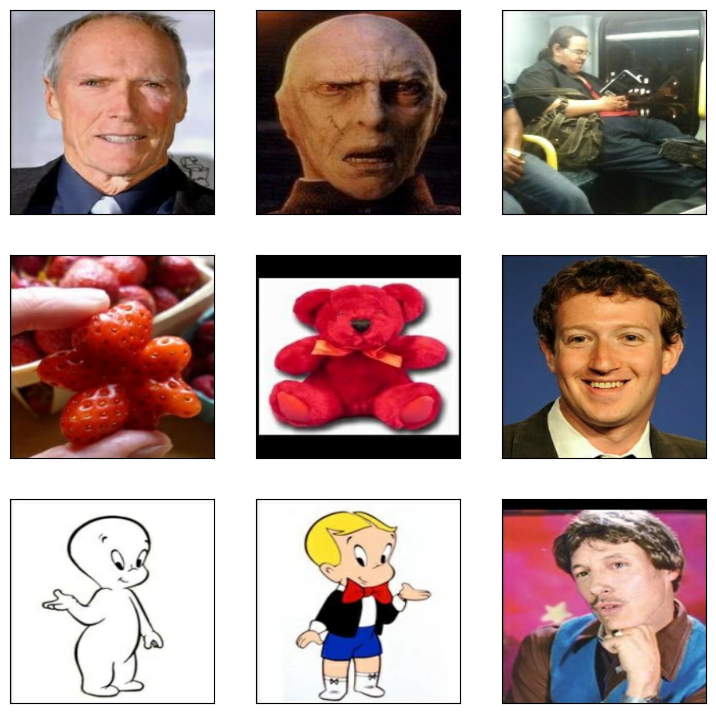

In [6]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_ds.take(1).as_numpy_iterator())[0])

# Model

In [7]:
base_cnn = resnet.ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=target_shape + (3,),
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512,activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256,activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)


embedding = Model(base_cnn.input, output,name="embedding")
embedding.summary()

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [15]:
class DistanceLayer(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self,anchor,positive,negative):
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    return (ap_distance , an_distance)

In [16]:
anchor_input = layers.Input(name="anchor",shape=target_shape + (3,))
positive_input = layers.Input(name="positive",shape=target_shape + (3,))
negative_input = layers.Input(name="negative",shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(positive_input)),
    # embedding(anchor_input),
    # embedding(positive_input),
    # embedding(positive_input),
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_3  (None, 256, 256, 3)          0         ['anchor[0][0]']              
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.__operators__.getitem_4  (None, 256, 256, 3)          0         ['positive[0][0]']      

In [18]:
class SiameseModel(Model):
  def __init__(self, siamese_network, margin=0.5):
      super().__init__()
      self.siamese_network = siamese_network
      self.margin = margin
      self.loss_tracker = metrics.Mean(name="loss")

  def call(self, inputs):
      return self.siamese_network(inputs)

  def train_step(self, data):
      with tf.GradientTape() as tape:
          loss = self._compute_loss(data)
      gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
      self.optimizer.apply_gradients(
          zip(gradients, self.siamese_network.trainable_weights)
      )
      self.loss_tracker.update_state(loss)
      return {"loss": self.loss_tracker.result()}

  def test_step(self, data):
      loss = self._compute_loss(data)
      self.loss_tracker.update_state(loss)
      return {"loss": self.loss_tracker.result()}

  def _compute_loss(self, data):
      ap_distance, an_distance = self.siamese_network(data)
      loss = ap_distance - an_distance
      loss = tf.maximum(loss + self.margin, 0.0)
      return loss

  @property
  def metrics(self):
    return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(model)
siamese_model.compile(optimizer=optimizers.Adam(0.0001),
        metrics='accuracy')
siamese_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 97s 632ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 82s 619ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 82s 623ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 82s 625ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 82s 624ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 82s 619ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

132/132 [==============================] - 83s 631ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 8/10
132/132 [==============================] - ETA: 0s - loss: 0.5000

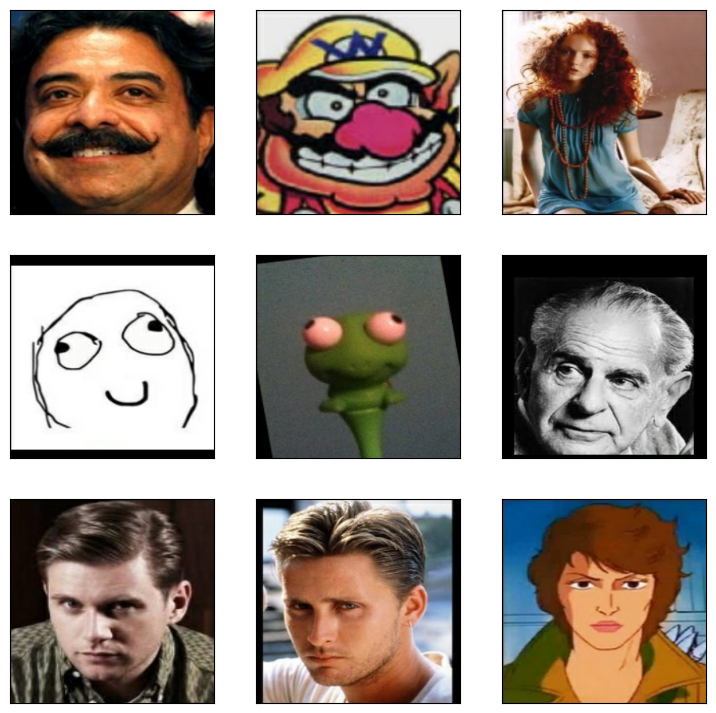

In [23]:
sample = next(iter(val_ds))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [24]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99400085
Negative similarity 0.9926057
